In [6]:
import sys

from pathlib import Path
from datetime import timedelta

import seaborn as sns
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange # 작업이 잘 돼가는지 확인하는 툴, trange(i)는 특별한 최적화 인스턴스다. tqdm(range(i))와 같은 기능이다.


#from TaPR_pkg import etapr

In [7]:
TRAIN_DATASET = sorted([x for x in Path("C:/Users/5788j/Desktop/데이콘 보안 탐지 딥러닝 데이터/dacon boan/HAI 2.0/training/").glob("*.csv")])

TEST_DATASET = sorted([x for x in Path("C:/Users/5788j/Desktop/데이콘 보안 탐지 딥러닝 데이터/dacon boan/HAI 2.0/testing/").glob("*.csv")])

VALIDATION_DATASET = sorted([x for x in Path("C:/Users/5788j/Desktop/데이콘 보안 탐지 딥러닝 데이터/dacon boan/HAI 2.0/validation/").glob("*.csv")])

In [8]:
# 함수 지정
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

# 함수 적용
TRAIN_DF_RAW=dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW


TEST_DF_RAW=dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

VALIDATION_DATASET_RAW=dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DATASET_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


In [9]:
# 컬럼 분류
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

# 학습 데이터셋의 최대, 최소값
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

# attack 컬럼 min-max정규화 함수
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:    # 최대값 최소값이 똑같은 컬럼
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

# CHECH_DIST EDA를 위한 전처리

In [10]:
CD_TEST=pd.read_csv('CHECK_DIST_VALIDATION_45best.csv')
CD_VAL=pd.read_csv('CHECK_DIST_45best.csv')

In [11]:
ANOMALY_SCORE = np.mean(CD_VAL, axis=1)

In [12]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [13]:
THRESHOLD = 0.04
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (43112,))

In [14]:
real_att=pd.DataFrame(VALIDATION_DATASET_RAW['attack'].iloc[89:]).reset_index()['attack']
real_att

0        0
1        0
2        0
3        0
4        0
        ..
43107    0
43108    0
43109    0
43110    0
43111    0
Name: attack, Length: 43112, dtype: int64

In [15]:
CD_VAL=pd.concat([CD_VAL,pd.DataFrame(LABELS),real_att],axis=1)

In [16]:
CD_VAL.columns=[     '0',      '1',      '2',      '3',      '4',      '5',      '6',
            '7',      '8',      '9',     '10',     '11',     '12',     '13',
           '14',     '15',     '16',     '17',     '18',     '19',     '20',
           '21',     '22',     '23',     '24',     '25',     '26',     '27',
           '28',     '29',     '30',     '31',     '32',     '33',     '34',
           '35',     '36',     '37',     '38',     '39',     '40',     '41',
           '42',     '43',     '44',     '45',     '46',     '47',     '48',
           '49',     '50',     '51',     '52',     '53',     '54',     '55',
           '56',     '57',     '58',     '59',     '60',     '61',     '62',
           '63',     '64',     '65',     '66',     '67',     '68',     '69',
           '70',     '71',     '72',     '73',     '74',     '75',     '76',
           '77',     '78',     'model_attack', 'real_attack']

In [17]:
CD_VAL[CD_VAL['model_attack']==1].shape[0],CD_VAL[CD_VAL['real_attack']==1].shape[0]

(658, 629)

In [18]:
print(CD_VAL[CD_VAL['model_attack']==1].shape[0]-CD_VAL[CD_VAL['real_attack']==1].shape[0],'의 차이')

29 의 차이


# **model이 예측한 어택을 1,2,3,4,5로 나누기**

In [19]:
a=[]
for i in range(1,CD_VAL[CD_VAL['model_attack']==1].shape[0]) : 
    if CD_VAL[CD_VAL['model_attack']==1].index[i]-CD_VAL[CD_VAL['model_attack']==1].index[i-1] != 1 :
        a.append(i)

In [20]:
a

[133,
 134,
 136,
 137,
 142,
 143,
 144,
 145,
 146,
 363,
 364,
 365,
 367,
 368,
 369,
 371,
 375,
 377,
 438,
 497,
 580]

In [21]:
# 분류해볼 수 있음
CD_VAL[CD_VAL['model_attack']==1].index[a]

Int64Index([ 8839,  8841,  8922,  8926,  8933,  8937,  8949,  8954, 14283,
            14501, 14506, 14509, 14515, 14519, 14526, 14530, 14535, 19178,
            19268, 21718, 21808],
           dtype='int64')

In [22]:
a2=[]
for i in range(1,CD_VAL[CD_VAL['model_attack']==1].shape[0]) : 
    if CD_VAL[CD_VAL['model_attack']==1].index[i]-CD_VAL[CD_VAL['model_attack']==1].index[i-1] >= 100 :
        a2.append(i)

In [23]:
#0~133 (134,136,137,142) att1
#146~
a2

[133, 146, 377, 497]

In [24]:
b=[]
for i in range(1,CD_VAL[CD_VAL['real_attack']==1].shape[0]) : 
    if CD_VAL[CD_VAL['real_attack']==1].index[i]-CD_VAL[CD_VAL['real_attack']==1].index[i-1] != 1 :
        b.append(i)

In [27]:
b

[192, 290, 480, 540]

# 어택 1을 먼저 분석해봄

In [25]:
print(CD_VAL[CD_VAL['real_attack']==1].index[:192],'\n','\n', '**실제 어택은 2022~2213까지 총 192개**','\n','-'*100,
      '\n',CD_VAL[CD_VAL['model_attack']==1].index[:133]),'-'*100,'**모델 어택은 2093~2225까지 총 133개**'

Int64Index([2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
            ...
            2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213],
           dtype='int64', length=192) 
 
 **실제 어택은 2022~2213까지 총 192개** 
 ---------------------------------------------------------------------------------------------------- 
 Int64Index([2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102,
            ...
            2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225],
           dtype='int64', length=133)


(None,
 '----------------------------------------------------------------------------------------------------',
 '**모델 어택은 2093~2225까지 총 133개**')

### 1.모델과 실제 레이블이 2093 ~ 2213 120개는 정답 
### 2. 2022 ~ 2092 71개는 어택을 정상으로 간주했음    <-- 더 중요한 부분임   (이것을 문제1로 분류)
### 3. 2214 ~ 2225 12개는 정상을 어택으로 간주함                            (이것을 문제 2로 분류)
### 4. 중요도 : 문제 1 >>>>> 문제2

## **먼저 어택이 겹치는 부분 전체 2022~2225를 시각화해봄**

' 나머지 빨간선을 넘은 변수도 중요하지만 1,74번 변수가 매우 중요해 보임'

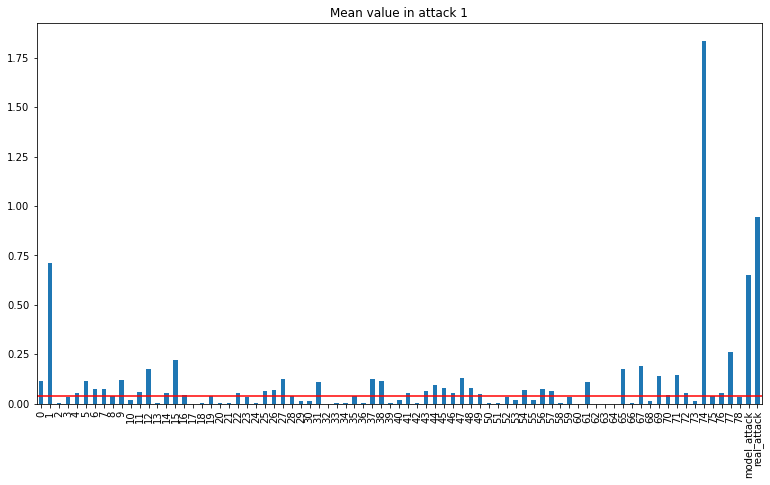

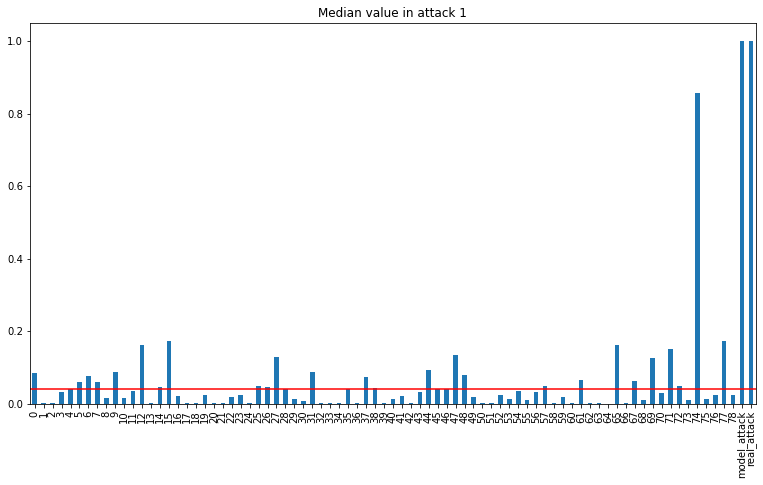

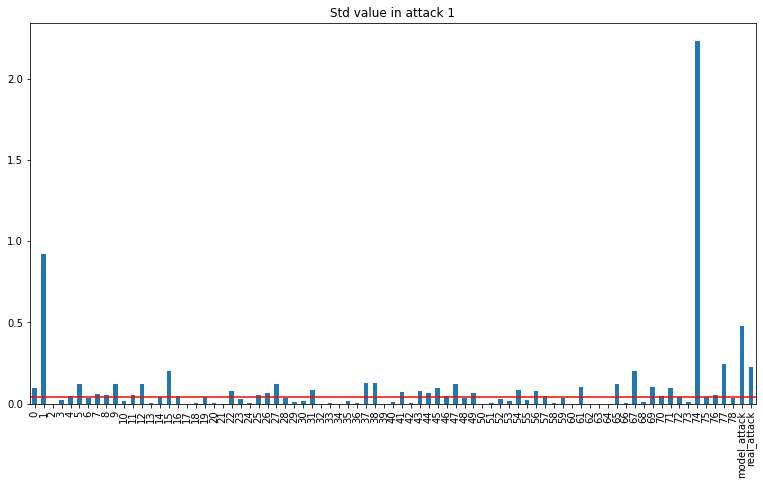

In [26]:
# 2022~ 2225 시퀀스의 각 피쳐별 평균, 중앙값, 편차를 시각화

f, ax = plt.subplots(1,1)
plt.title('Mean value in attack 1')
CD_VAL.iloc[2022:2225].mean().plot.bar(figsize=(13,7))
plt.axhline(y=0.04, color='r')

f, ax = plt.subplots(1,1)
plt.title('Median value in attack 1')
CD_VAL.iloc[2022:2225].median().plot.bar(figsize=(13,7))
plt.axhline(y=0.04, color='r')

f, ax = plt.subplots(1,1)
plt.title('Std value in attack 1')
CD_VAL.iloc[2022:2225].std().plot.bar(figsize=(13,7))
plt.axhline(y=0.04, color='r')

''' 나머지 빨간선을 넘은 변수도 중요하지만 1,74번 변수가 매우 중요해 보임'''

## 처음부터 빨간선 까지가 실제 어택1, 초록색선 부터 끝까지가 모델의 어택1 
## 즉, 앞에 71개의 어택을 못맞추고 뒤에 12개의 정상부분을 틀린 것임
## **초록색 선 앞 쪽은 높은 오차를 가지고(문제1) 빨간선 뒤로는 작은 오차를 가지는(문제 2) 변수를 찾으려함**

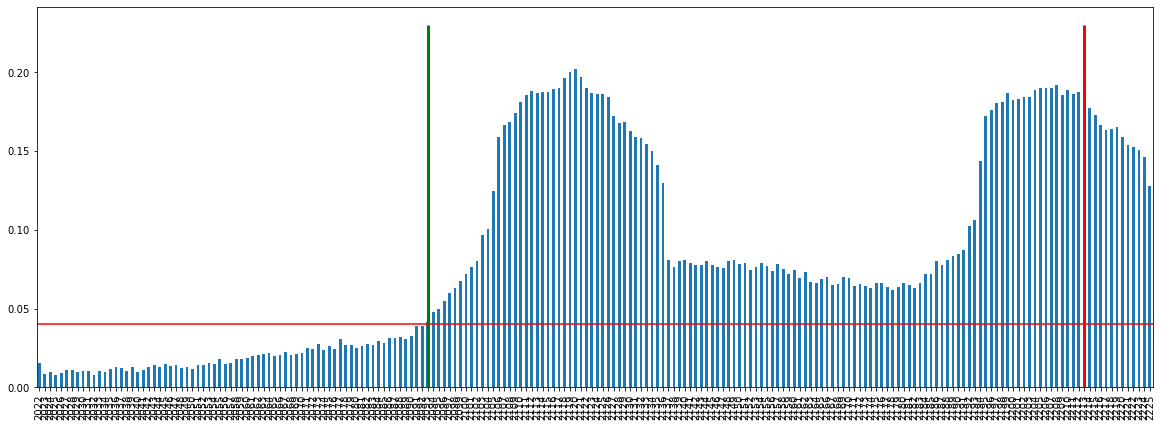

In [29]:
CD_VAL.iloc[2022:2226,:79].mean(axis=1).plot.bar(figsize=(20,7))
plt.axhline(y=0.04, color='r')
plt.vlines(191, 0, 0.23, colors='red', linewidth=3)
plt.vlines(71, 0, 0.23, colors='green', linewidth=3)

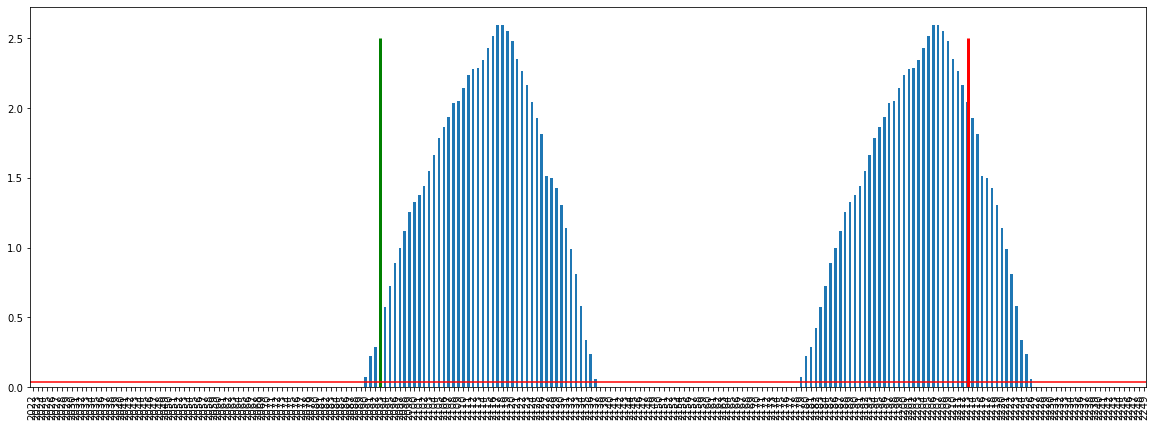

In [303]:
CD_VAL['1'].iloc[2022:2250].plot.bar(figsize=(20,7))
plt.axhline(y=0.04, color='r')
plt.vlines(191, 0, 2.5, colors='red', linewidth=3)
plt.vlines(71, 0, 2.5, colors='green', linewidth=3)

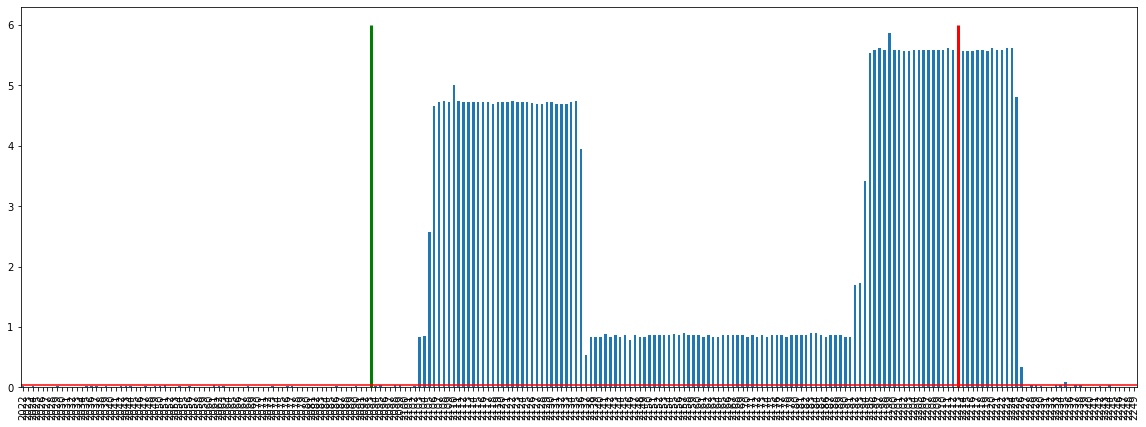

In [302]:
CD_VAL['74'].iloc[2022:2250].plot.bar(figsize=(20,7))
plt.axhline(y=0.04, color='r')
plt.vlines(191, 0, 6, colors='red', linewidth=3)
plt.vlines(71, 0, 6, colors='green', linewidth=3)

# 변수 1과 74는 정상인 범주를 어택으로 간주(문제 2) 빨간선 뒤에만 간섭하므로 초록선 앞쪽의 문제1을 해결할 수 없음

## 더 오차가 많은 초록색 앞 부분을 분석해 보려했는데
## 초록색 선 앞을 어택이라고 간주하는(문제1) 상위 12개의 변수가 , 대부분 빨간선 뒤로도 오차로(문제2) 간주해버림
## -> 즉, 문제 1을 해결할 상위 12개의 변수가 대부분 문제 2를 일으키는 상위 변수임


In [ ]:
problem_1=CD_VAL.iloc[2022:2093,0:79].mean().sort_values(ascending=False).head(12).index
problem_1

In [317]:
problem_2=CD_VAL.iloc[2225:2300,0:79].mean().sort_values(ascending=False).head(12).index

In [239]:
# 위에 두개의 컬럼 집합의 컬럼 원소들이 거의 겹침

Index(['65', '12', '71', '48', '6', '7', '31', '69', '61', '46', '37', '44'], dtype='object')

# 이런식으로 문제1은 잘 해결하지만, 뒤에 문제 2를 만드는 원인이 되는 컬럼이었음

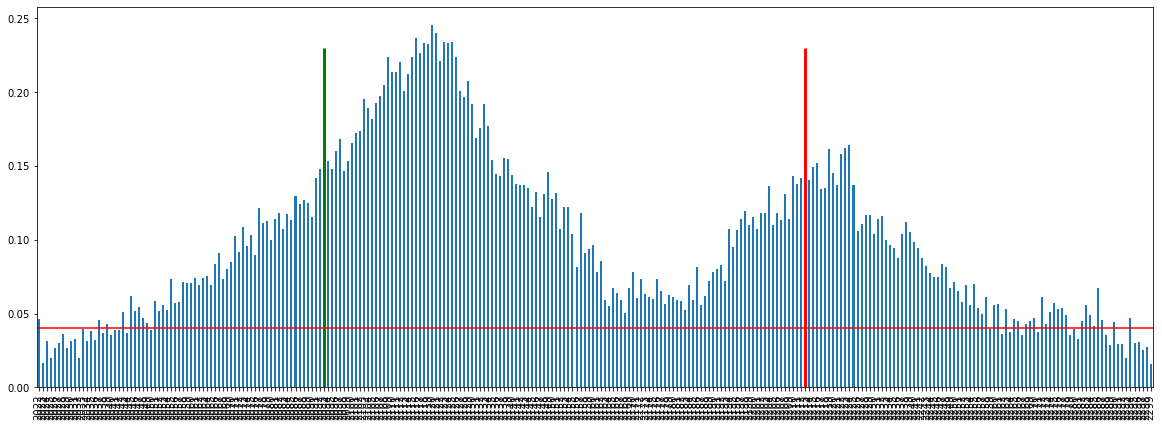

In [319]:
import warnings
warnings.filterwarnings('ignore')

# 문제1을 해결해주는 상위 12개의 변수들의 평균을 그래프로 시각화

CD_VAL[problem_1].mean(axis=1).iloc[2022:2300].plot.bar(figsize=(20,7))
plt.axhline(y=0.04, color='r')
plt.vlines(191, 0, 0.23, colors='red', linewidth=3)
plt.vlines(71, 0, 0.23, colors='green', linewidth=3)

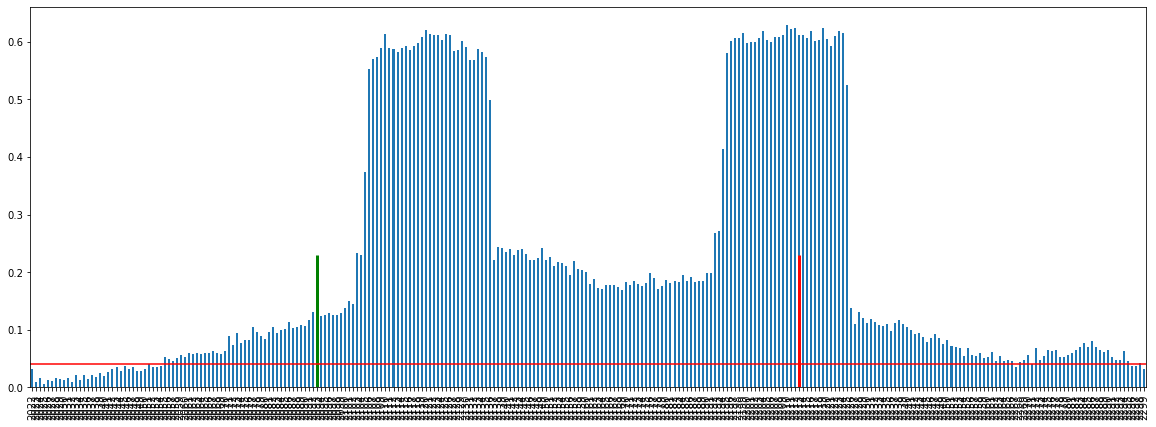

In [320]:

# 문제2를 일으키는 상위 12개의 변수들의 평균을 그래프로 시각화


CD_VAL[problem_2].mean(axis=1).iloc[2022:2300].plot.bar(figsize=(20,7))
plt.axhline(y=0.04, color='r')
plt.vlines(191, 0, 0.23, colors='red', linewidth=3)
plt.vlines(71, 0, 0.23, colors='green', linewidth=3)